# Ussing CNN to classify indivudual bopomofo chracters

### Overview

My goal is to train a model that can recognize Bopomofo characters

#### First attempt with limited training set
I created this training set by taking screenshots and taking pictures, the characters were all written in the same order. I then split the big image into squares, each with one character inside.

And because the screenshot was not always precise, the split image result was often off-center in a certain way.

I tested the model ("session_id": 32, "timestamp": "2024-12-12T00:14:09") with various datasets.
I found that the model performed better on computer fonts than on handwritten characters. But if I only put my handwritten character in, it gets around the same accuracy as on computer font, which is about 84%. 

For the prediction mentioned above, my characters are in a very different order than in the training set for the model. 

Further experiments showed that when the testing set has the same character order as the training set, the accuracy is improved by 10%. Handwriting characters by the same person(Jacob) changed from 65% accuracy to 74% accuracy. A computer font (17 ToneOZ-Zhuyin-Tsuipita-TC) changed from 85% to 95% accuracy.

I think the model might have memorized the position of the character in the picture instead of just the shape of the character. 

#### Second attempt
I used various methods to create randomly off-center images as well as changing the contrast, slanting the image and making it burrly. The result is I have at least 2 times more training data than the first attempt. This greatly improves the model's performance and generalization.

I found that I can generate each character in its own image with Python, which is much faster and provides me with more options to adjust the image. 

To make the training dataset more balanced, and add in the different font weights, I grouped the fonts into four types: even strokes, dynamic strokes, heavily stylized, and handwritten fonts. Then applying more augmentation to reflect how written characters look like.

This strategy worked, and not only did the model need much fewer epochs to train (from 200 to 30), but it also had improved performance, depending on the test data, it could have 75-100% accuracy. Even the handwriting often got a 75-85% accuracy. Though more off-centered images still decrease the prediction accuracy, it is now less biased.

In [1]:
# import libraries

# image processing
from PIL import Image, ImageDraw, ImageFont
import cv2
import random

# image manipulation and machine learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


# file name handling
import os
import shutil # for cleaning folders (deleting everything)

# Data Handling and Analysis
import pandas as pd
import numpy as np
import json # to record training result
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import datetime # for timestamp in log

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare and process training data
- Computer fonts
- Handwritten characters

#### Handwritten characters
The characters are written in a grid format, each grid has a full set of 37 characters. They need to be split into individual images and scales to the proper size.<br>
Because there are only two sets of Hanwrittan characters I will implement elastic transformations and Gaussian blur to help improve variation.

#### Load the images and split into individual characters
- Include scaling so the final character images are 28*28 pixels each

In [2]:
def extract_info_from_filename(filename):
    """Extract font number and note from the filename."""
    parts = filename.split('_')
    font_num = parts[0]
    font_note = parts[1]
    return font_num, font_note


# I have all bpm(bopomofo) characters in one bigger png, 
# and the name of these png file are fontNum_fontNote_all.png
    

In [3]:
# Delete everything in the specified folder
def clear_folder(folder_path):
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Remove all files and subdirectories in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove the file or symbolic link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove the directory and its contents
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        print(f"The folder {folder_path} does not exist.")

    print("Function clear_folder has completed.")

In [4]:
def split_image_with_extracted_names(char_numbers, image_path, output_dir, grid_size=(3, 14)):
    """
    Split an image into smaller chunks and name each piece.

    Parameters
      char_numbers: A nested list(matrix) that will determine the charNum for each output image.
          I have a grid of 3 rows and 14 cols, so my matrix is also 3 rows and 14 cols.
      image_path: Path to an image file that contains all 37 bpm char for a font.
      output_dir: Where the split image will be.
      grid_size: (number_of_rows, number_of_columns) how the 37 bpm is placed in the image.
          Default grid_size is (3, 14)

    Output
      Individual characters each in one png file.
      file name formate: characterNum_fontNum_fontNote.png
      fontNote example: bold, italic, regular...
      Ex: 01_15_A.png would be for character 01 (ㄅ) from font 15.
    
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract filename info
    base_filename = os.path.basename(image_path)
    font_num, font_note = extract_info_from_filename(base_filename)
    
    # Open the image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Calculate the size of each cell
    cell_width = img_width // grid_size[1]
    cell_height = img_height // grid_size[0]

    # Ensure the number of cells matches the grid size 
    if len(char_numbers) != grid_size[0] or any(len(row) != grid_size[1] for row in char_numbers): 
        raise ValueError("Character numbers list does not match the grid size.")

    # Split the image into smaller cells
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            left = col * cell_width
            upper = row * cell_height
            right = left + cell_width
            lower = upper + cell_height
            cell_img = img.crop((left, upper, right, lower))

            # Determine the character number
            char_num = char_numbers[row][col]
            # bpm only goes from 1 to 37, skip the empty cells
            if char_num > 37:
                continue
            
            # Create the filename
            filename = f'{char_num:02d}_{font_num}_{font_note}.png'
            
            # Save the cell image
            cell_img.save(os.path.join(output_dir, filename))

In [5]:
def split_all_images(input_dir, output_dir, char_numbers, grid_size=(3, 14)):
    """
    Split all PNG images in the input directory.
    
    Parameters:
      input_dir: Directory containing the large images.
      output_dir: Directory to save the split images.
      char_numbers: A nested list (matrix) that will determine the charNum for each output image.
      grid_size: (number_of_rows, number_of_columns) for how the characters are placed in the image.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            image_path = os.path.join(input_dir, filename)
            split_image_with_extracted_names(char_numbers, image_path, output_dir, grid_size)


In [6]:
def scale_and_pad_image(input_dir, output_dir, target_size=(28, 28)):
    """
    Scale and pad images to the target size while maintaining proportions.

    Assume each 
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            img = Image.open(os.path.join(input_dir, filename))
            img.thumbnail(target_size, Image.LANCZOS)  # Maintain aspect ratio
            width, height = img.size

            # Create a new image with white background
            new_img = Image.new('RGB', target_size, (255, 255, 255))
            paste_position = ((target_size[0] - width) // 2, (target_size[1] - height) // 2)
            new_img.paste(img, paste_position)
            new_img.save(os.path.join(output_dir, filename))


In [7]:
# Function to load and visualize images in a folder
def visualize_samples(data_dir, sample_num=5, figuresize=(10,5), is_sample=True, title_fontsize=12):
    filenames = os.listdir(data_dir)[:sample_num]
    plt.figure(figsize=figuresize)
    for i, filename in enumerate(filenames):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path)
        if is_sample:
            plt.subplot(1, sample_num, i+1)
        else:
            plt.subplot(sample_num, 1, i+1) # stack vertically - set col to 1 and row to i+1
        plt.imshow(img, cmap='gray')
        plt.title(filename, fontsize=title_fontsize)
        plt.axis('off') # maintain the original figure's aspect ratio
    plt.show()

# Usage examples
# data_dir = 'fonts_processed_scaled'
# visualize_samples(data_dir)

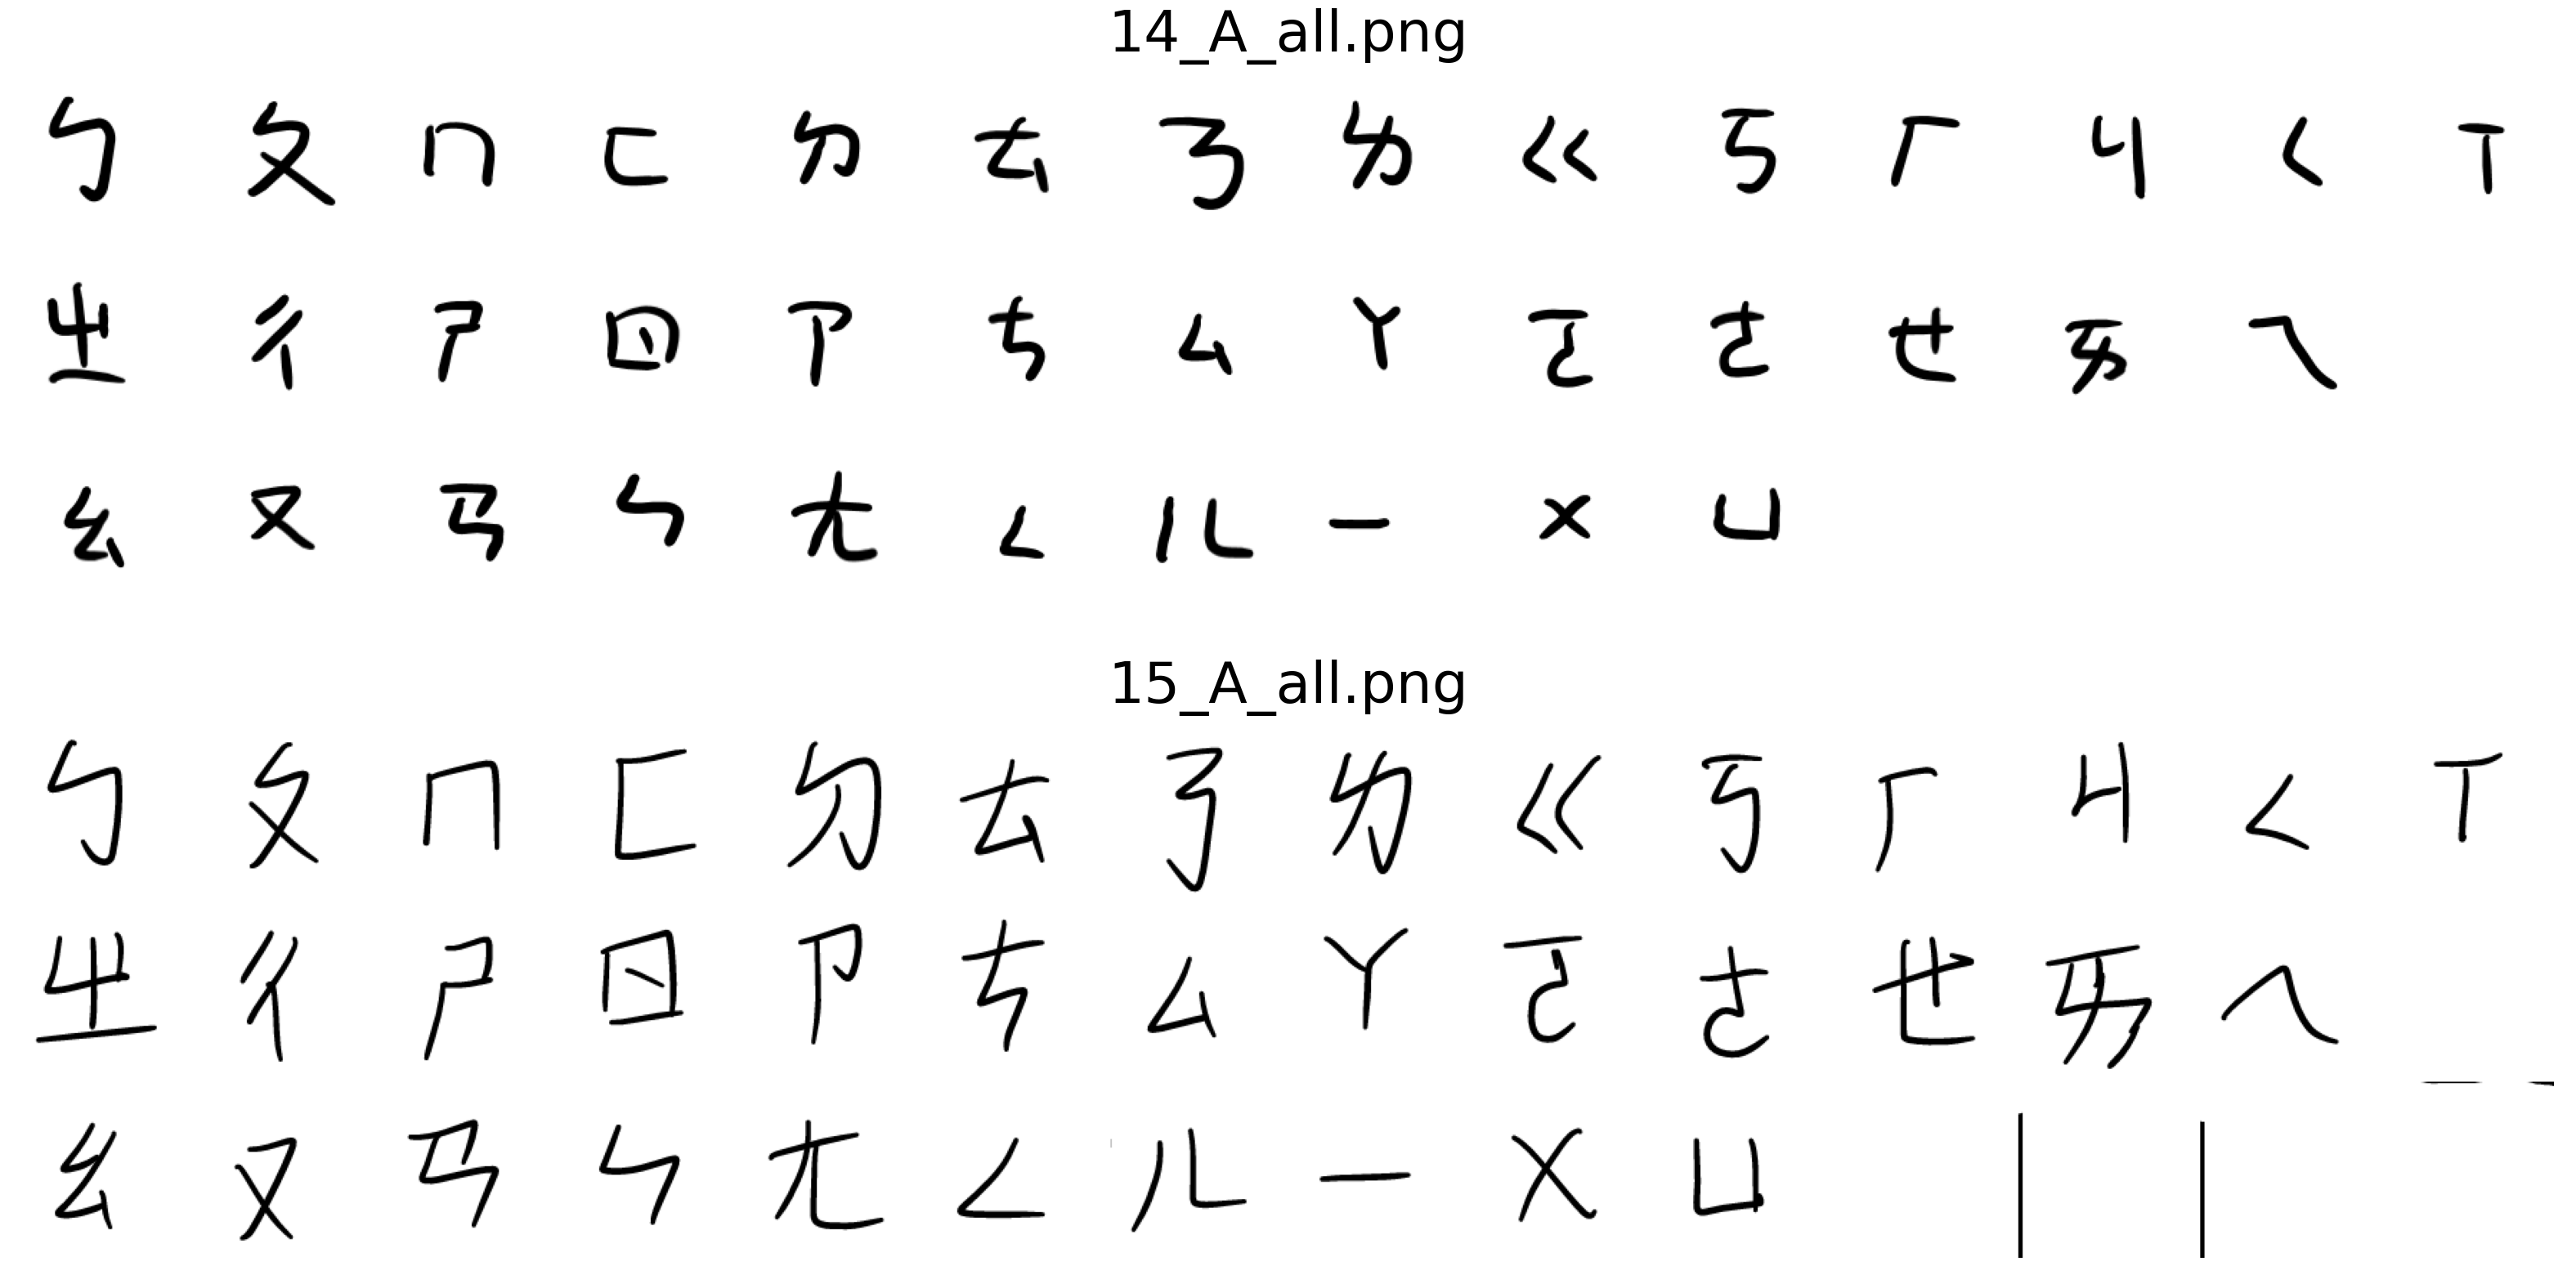

In [8]:
# Show the original handwritten images

data_dir = r'fonts_original files\handwritten fonts'
visualize_samples(data_dir, figuresize=(100,50), is_sample=False, title_fontsize=50)

In [9]:
# Only charNum 01-37 contain charactes, 38-42 are just blank.
char_numbers = [
    list(range(1, 15)),   # Top row: 01-14
    list(range(15, 28)) + [38],  # Middle row: 15-17, 38
    list(range(28, 38)) + list(range(39, 43))  # Bottom row: 28-37, 39-42
]

# Check if the charNum matches the grid
print(char_numbers)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38], [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42]]


In [10]:
# input and output folder for image processing
input_dir = r'fonts_original files\handwritten fonts'
split_output_dir = r'processing image\train handwriting split'
augmented_output_dir = r'processing image\train handwriting augmented'
scaled_output_dir = 'fonts - processed and scaled'

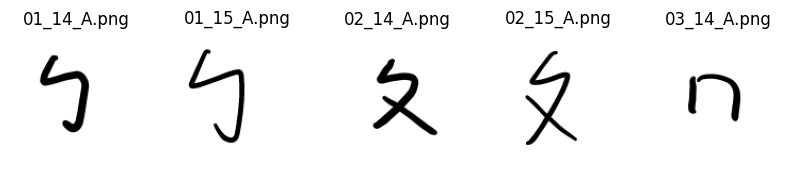

In [11]:
# Split the image in the input directory
split_all_images(input_dir, split_output_dir, char_numbers)

# Show the split images
visualize_samples(split_output_dir)

In [12]:
# for hand writting
# functions to randomly alter images to create variety

# Function to apply slanting with random factor
def apply_slant(image):
    slant_factor = np.random.uniform(-0.3, 0.3)
    rows, cols = image.shape
    M = np.float32([[1, slant_factor, 0], [0, 1, 0]])
    slanted_img = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return slanted_img

# Function to apply rotation with random angle
def apply_rotation(image):
    angle = np.random.uniform(-15, 15)
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_img = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return rotated_img

# Function to apply Gaussian blur with a random kernel size
def apply_gaussian_blur(image, min_kernel_size=3, max_kernel_size=9):
    # Ensure kernel size is odd and within the specified range
    kernel_size = np.random.choice(range(min_kernel_size, max_kernel_size + 1, 2))
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Function to adjust contrast with random alpha and beta
def adjust_contrast(image):
    alpha = np.random.uniform(0.9, 1.0) # randomly lower contrast
    beta = np.random.uniform(0, 20) # randomly adjust brightness

    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)


# Function to augment the image
def augment_image(img_path, output_dir, num_augmentations=4):
    filename = os.path.basename(img_path)
    char, font_name, note = filename.split('_')
    note = note.split('.')[0]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    for i in range(num_augmentations):
        if i == 0: # keep original split image
            final_img = img
        else:         
            slanted_img = apply_slant(img)
            rotated_img = apply_rotation(slanted_img)
            contrasted_img = adjust_contrast(rotated_img)
            blurred_img = apply_gaussian_blur(contrasted_img)
            final_img = blurred_img

        output_path = os.path.join(output_dir, f"{char}_{font_name}_augmented{i}.png")
        cv2.imwrite(output_path, final_img)

def process_images_in_folder(input_dir, output_dir, num_augmentations=5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for filename in os.listdir(input_dir):
        if filename.endswith(".png"):
            img_path = os.path.join(input_dir, filename)
            augment_image(img_path, output_dir, num_augmentations)
    print("All image created successfully")


The folder augmented_output_dir does not exist.
Function clear_folder has completed.
All image created successfully


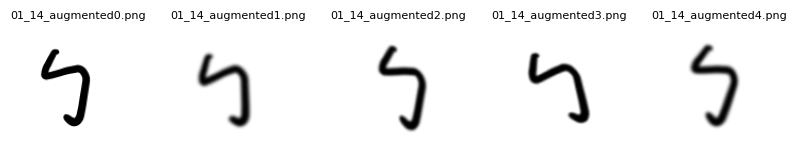

In [13]:
# clear folder before putting in new image
folder_path = 'augmented_output_dir'
clear_folder(folder_path)

# create augmented images from original image
process_images_in_folder(split_output_dir, augmented_output_dir, num_augmentations=5)

# Show the augmented images
visualize_samples(augmented_output_dir, title_fontsize=8)

In [14]:
# clear the "fonts - processed and scaled" folder before putting in new image
folder_path = 'scaled_output_dir'
clear_folder(folder_path)

The folder scaled_output_dir does not exist.
Function clear_folder has completed.


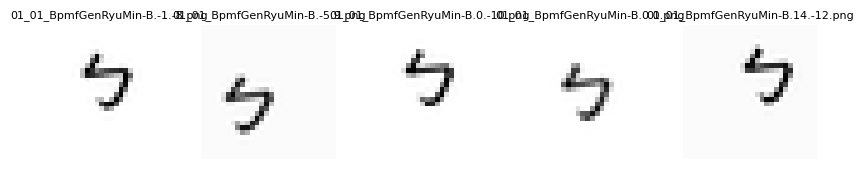

In [15]:
# Scale and pad images

target_size = (28, 28)  # Desired size for training

scale_and_pad_image(augmented_output_dir, scaled_output_dir, target_size)

visualize_samples(scaled_output_dir, title_fontsize=8)

#### Computer fonts
These are generated by using the font file (ttf and otf). <br>
Then altered to create more diversity, including rotation, changing contrast, etc.

In [16]:
# Functions to get gile names and paths

def list_files_in_directory(directory_path):
    all_items = os.listdir(directory_path) 
    files = [item for item in all_items if os.path.isfile(os.path.join(directory_path, item))] 
    return files

# create a list of file path from specified folder
def create_file_paths(directory_path):
    file_names = list_files_in_directory(directory_path)
    file_paths = [os.path.join(directory_path, file_name).replace("\\", "/") for file_name in file_names]
    return file_paths

# example
# directory_path = "fonts_original files/even stroke fonts"
# file_paths = create_file_paths(directory_path)

In [17]:
# Get all the computer font path
computer_fonts_folder = [
    'fonts_original files/dynamic stroke fonts',
    'fonts_original files/even stroke fonts',
    'fonts_original files/heavily stylized fonts'
]

fonts_list = []
for folder in computer_fonts_folder:
    directory_path = folder
    font_list = (create_file_paths(directory_path))
    fonts_list += font_list

print(f"\nThere are {len(fonts_list)} computer font files in total")
print(f"Note: Different font weight of the same font have its own font file (ttf)")
print("\nList of font files path:")
print(fonts_list)


There are 55 computer font files in total
Note: Different font weight of the same font have its own font file (ttf)

List of font files path:
['fonts_original files/dynamic stroke fonts/01_BpmfGenRyuMin-B.ttf', 'fonts_original files/dynamic stroke fonts/01_BpmfGenRyuMin-EL.ttf', 'fonts_original files/dynamic stroke fonts/01_BpmfGenRyuMin-H.ttf', 'fonts_original files/dynamic stroke fonts/01_BpmfGenRyuMin-L.ttf', 'fonts_original files/dynamic stroke fonts/01_BpmfGenRyuMin-M.ttf', 'fonts_original files/dynamic stroke fonts/01_BpmfGenRyuMin-R.ttf', 'fonts_original files/dynamic stroke fonts/01_BpmfGenRyuMin-SB.ttf', 'fonts_original files/dynamic stroke fonts/02_BpmfGenWanMin-EL.ttf', 'fonts_original files/dynamic stroke fonts/02_BpmfGenWanMin-L.ttf', 'fonts_original files/dynamic stroke fonts/02_BpmfGenWanMin-M.ttf', 'fonts_original files/dynamic stroke fonts/02_BpmfGenWanMin-R.ttf', 'fonts_original files/dynamic stroke fonts/02_BpmfGenWanMin-SB.ttf', 'fonts_original files/dynamic stroke

In [18]:
# get a list of character tuples (char_num, char)
# char_pairs = [(1,'ㄅ'), (2,'ㄆ'), (3,'ㄇ')...]

characters = [
    'ㄅ', 'ㄆ', 'ㄇ', 'ㄈ', 'ㄉ', 'ㄊ', 'ㄋ', 'ㄌ', 
    'ㄍ', 'ㄎ', 'ㄏ', 'ㄐ', 'ㄑ', 'ㄒ', 'ㄓ', 'ㄔ', 'ㄕ', 'ㄖ', 
    'ㄗ', 'ㄘ', 'ㄙ', 'ㄚ', 'ㄛ', 'ㄜ', 'ㄝ', 'ㄞ', 'ㄟ', 
    'ㄠ', 'ㄡ', 'ㄢ', 'ㄣ', 'ㄤ', 'ㄥ', 'ㄦ', 'ㄧ', 'ㄨ', 'ㄩ'
]

char_pairs = []
char_num = 0
for char in characters:
    char_num += 1
    char_pairs.append((char_num, char))

print(char_pairs)

[(1, 'ㄅ'), (2, 'ㄆ'), (3, 'ㄇ'), (4, 'ㄈ'), (5, 'ㄉ'), (6, 'ㄊ'), (7, 'ㄋ'), (8, 'ㄌ'), (9, 'ㄍ'), (10, 'ㄎ'), (11, 'ㄏ'), (12, 'ㄐ'), (13, 'ㄑ'), (14, 'ㄒ'), (15, 'ㄓ'), (16, 'ㄔ'), (17, 'ㄕ'), (18, 'ㄖ'), (19, 'ㄗ'), (20, 'ㄘ'), (21, 'ㄙ'), (22, 'ㄚ'), (23, 'ㄛ'), (24, 'ㄜ'), (25, 'ㄝ'), (26, 'ㄞ'), (27, 'ㄟ'), (28, 'ㄠ'), (29, 'ㄡ'), (30, 'ㄢ'), (31, 'ㄣ'), (32, 'ㄤ'), (33, 'ㄥ'), (34, 'ㄦ'), (35, 'ㄧ'), (36, 'ㄨ'), (37, 'ㄩ')]


In [19]:
# input and output folder for computer fonts image processing

# fonts_list: already created, contains all computer font path
generated_output_dir = r'processing image\train computer off-centered'
augmented_output_dir = r'processing image\train computer agumented'
scaled_output_dir = 'fonts - processed and scaled'

#### Generate computer font image from font file (ttf, otf)
When first generated, each font has five versions, one where it is centered, and four where it is randomly placed in the square. This is to create variation and make the model more robust.

In [20]:
# function to generate centered and off-centered images for each ttf or otf font file
def generate_images(fonts_list, char_pairs, output_dir, num_variations=5, offset_range=(-15, 15)):
    for font_path in fonts_list:
        font_name = os.path.basename(font_path).split('.')[0]
        font = ImageFont.truetype(font_path, size=50)

        for char_pair in char_pairs:
            char = char_pair[1]
            char_num = char_pair[0]
            for i in range(num_variations):  # Generate specified number of variations
                img = Image.new('RGB', (100, 100), color=(255, 255, 255))
                draw = ImageDraw.Draw(img)
                bbox = draw.textbbox((0, 0), char, font=font)
                w = bbox[2] - bbox[0]
                h = bbox[3] - bbox[1]

                # Random offset generation
                if i == 0:
                    offset = (0, 0)  # Centered
                else:
                    offset = (
                        random.randint(offset_range[0], offset_range[1]), 
                        random.randint(offset_range[0], offset_range[1])
                    )

                if font_name == '11_BpmfZihiOnly-R':
                    x = (100 - w) / 2 + offset[0]
                    y = (100 - w) / 2 + offset[1]
                    
                elif font_name in ('12_elffont-rock', '13_elffont-fern'):
                    # special setting to avoid being cropped
                    offset = (random.randint(-20, 20), random.randint(-15, 5))
                    x = (100 - w) / 2 + offset[0]
                    y = (-16) + (100 - w) / 2 + offset[1]
                
                else:
                    x = 12 + (100 - w) / 2 + offset[0]
                    y = 12 + (100 - w) / 2 + offset[1]

                draw.text((x, y), char, font=font, fill=(0, 0, 0))

                # Save the image
                img.save(os.path.join(output_dir, f"{char_num:02}_{font_name}.{offset[0]}.{offset[1]}.png"))
    print("All image generated: including centered and off-centered image")
    

Function clear_folder has completed.
All image generated: including centered and off-centered image


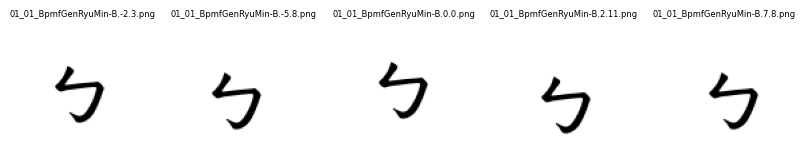

In [21]:
# clear the folder before putting in new image
folder_path = generated_output_dir
clear_folder(folder_path)

# Generate font images from font files with random offset 
output_dir = generated_output_dir
generate_images(fonts_list, char_pairs, output_dir, num_variations=5)
visualize_samples(output_dir, title_fontsize=6)

#### Apply alteration to computer font images
Alterations include:
- adjust image contrast and brightness
- apply_slant
- rotated image
- blur image with Gaussian blur

Becasue computer fonts are more uniform, mostly have higher quality (taken from screenshots), and are less likely to be disoriented, for roughly half of the font images, I did not apply extra alteration aside from adjusting contrast randomly. This is to better align with the general quality of computer fonts.

In [22]:
# for computer font
# functions to randomly alter images to create variety

# Flip between 1 and -1, determining what alteration will apply
# 1 for only applying contrast
only_contrast = 1


# Function to apply slanting with random factor
def apply_slant(image):
    slant_factor = np.random.uniform(-0.2, 0.2)
    rows, cols = image.shape
    M = np.float32([[1, slant_factor, 0], [0, 1, 0]])
    slanted_img = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return slanted_img

# Function to apply rotation with random angle
def apply_rotation(image):
    angle = np.random.uniform(-5, 5)
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_img = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return rotated_img

# Function to apply Gaussian blur with a random kernel size
def apply_gaussian_blur(image, min_kernel_size=3, max_kernel_size=5):
    # Ensure kernel size is odd and within the specified range
    kernel_size = np.random.choice(range(min_kernel_size, max_kernel_size + 1, 2))
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Function to adjust contrast with random alpha and beta
def adjust_contrast(image):
    alpha = np.random.uniform(0.95, 1.0) # randomly lower contrast
    beta = np.random.uniform(0, 10) # randomly adjust brightness

    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Function to augment the image
def augment_image(img_path, output_dir, only_contrast=only_contrast):
    filename = os.path.basename(img_path)
    char, font_name, note = filename.split('_')
    # note = '_'.join(parts[2:]) # Recombine the rest 
    note = note.rsplit('.', 1)[0]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded successfully 
    if img is None: 
        print(f"Error: Unable to load image at path {img_path}") 
        return

    if only_contrast == 1:
        final_img = adjust_contrast(img)
        only_contrast = only_contrast * (-1)
    else:
        only_contrast = only_contrast * (-1)
        slanted_img = apply_slant(img)
        rotated_img = apply_rotation(slanted_img)
        contrasted_img = adjust_contrast(rotated_img)
        blurred_img = apply_gaussian_blur(contrasted_img)
        final_img = blurred_img
    
    output_path = os.path.join(output_dir, f"{char}_{font_name}_{note}.png")
    cv2.imwrite(output_path, final_img)

    return only_contrast

def process_images_in_folder(input_dir, output_dir):
    global only_contrast # change the global variable inside a function to ensure consistancy
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for filename in os.listdir(input_dir):
        if filename.endswith(".png"):
            img_path = os.path.join(input_dir, filename)
            only_contrast = augment_image(img_path, output_dir, only_contrast)
    print("All image generated")


Function clear_folder has completed.
All image generated


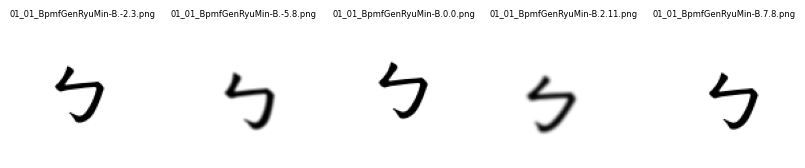

In [23]:
# clear the folder before putting in new image
folder_path = augmented_output_dir
clear_folder(folder_path)

# Create augmented images from original image
input_dir = generated_output_dir
output_dir = augmented_output_dir
process_images_in_folder(input_dir, output_dir)

# Show result
visualize_samples(output_dir, title_fontsize=6)

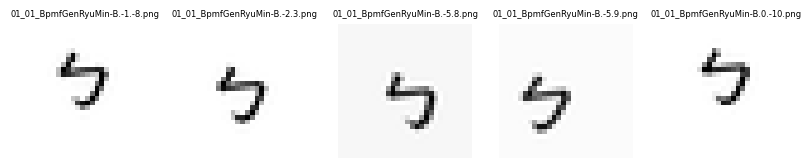

In [24]:
# Scale and pad images to the same size for training
input_dir = augmented_output_dir
output_dir = scaled_output_dir
target_size = (28, 28)  # Desired size for training

# Scale and pad images
scale_and_pad_image(input_dir, output_dir, target_size)
visualize_samples(output_dir, title_fontsize=6)

#### Data Exploration:
- Visualize Samples
- Class Distribution
    - See more details in "note.txt"

In [25]:
def visualize_random_samples(data_dir, sample_num=20, num_cols=5, figuresize=(10,6), title_fontsize=10):
    filenames = os.listdir(data_dir)
    if len(filenames) < sample_num:
        sample_num = len(filenames)  # Don't ask for more samples than available

    sample_filenames = random.sample(filenames, sample_num)

    # Calculate number of rows
    num_rows = (sample_num // num_cols) + (sample_num % num_cols > 0)  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figuresize)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust space between subplots

    for i, ax in enumerate(axes.flat):
        if i < sample_num:
            filename = sample_filenames[i]
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path)
            
            # Extract the first two sets of numbers for the title
            title = "_".join(filename.split('_')[:2])
            ax.imshow(img, cmap='gray')
            ax.set_title(title, fontsize=title_fontsize)

            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')  # Hide empty subplots

    plt.show()

# Usage examples
# data_dir = 'fonts_processed_scaled'
# visualize_samples(data_dir)


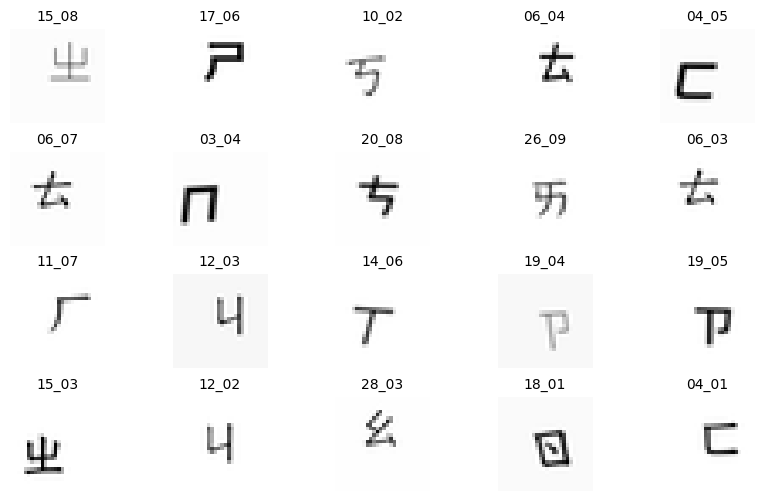

In [26]:
# Visualize some samples
data_dir = 'fonts - processed and scaled'
visualize_random_samples(data_dir)

#### Data distribution
- There are 15 fonts: 13 computer fonts + 2 handwritten fonts
- Becasue some fonts have up to seven font weught, and each font weight have its own font file, there are 55 conputer font fils in total.
- I grouped the 15 fonts into 4 catefory
    - dynamic stroke fonts - 7 fonts <br>
        29 font files in total

    - even stroke fonts - 4 fonts <br>
        24 font files in total
    
    - heavily stylized fonts - 2 fonts<br>
        12_elffont-rock.otf<br>
        13_elffont-fern.otf
    
    - handwritten fonts - 2 fonts<br>
        by me<br>
        by my brother
 
**Note**: see note.txt for more detail

#### Preprocessing:
- Normalization: Normalize the pixel values. Dividing by 255, so the scaled pixel values now range from 0 to 1, which helps the model converge faster.
- Data Augmentation: Apply data augmentation techniques such as rotation and scaling to artificially increase the size of the dataset and make the model more robust. Helps prevent overfitting.

In [27]:
# Load data, convert to gray scale,  and normalize
def load_and_preprocess_images(data_dir, target_size=(28, 28)):
    images = []
    labels = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert('L') # convert to grayscale
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize pixel values
            img = np.expand_dims(img, axis=-1) # add channel dimension
            label = int(filename.split('_')[0]) -1  # Extract (character number -1) as label with 0 index
            images.append(img)
            labels.append(int(label))
    return np.array(images), np.array(labels)

In [29]:
# Load and preprocess data
data_dir = 'fonts - processed and scaled'
images, labels = load_and_preprocess_images(data_dir)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Verify shapes and label range
# shape is (number of samples, height, width, channels)
# each image is 28*28 pixel and grayscale, so should be (number of samples, 28, 28, 1)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("Label range in y_train:", min(y_train), "to", max(y_train))


X_train shape: (14938, 28, 28, 1)
X_val shape: (3735, 28, 28, 1)
y_train shape: (14938,)
y_val shape: (3735,)
Label range in y_train: 0 to 36


#### Train and view result

In [30]:
# Function to train the model
def train_model(X_train, y_train, X_val, y_val, params):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(params['conv1_filters'], (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(params['conv2_filters'], (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(params['conv3_filters'], (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(params['dense_units'], activation='relu'),
        tf.keras.layers.Dropout(params['dropout_rate']),
        tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=params['epochs'])
    
    return model, history

In [31]:
# Function to log experiment results with incremental ID and timestamp
def log_experiment(params, history, log_file='model_training_log.json'):
    # Read existing log file to find the highest existing ID
    if os.path.exists(log_file):
        with open(log_file, 'r') as file:
            log_data = json.load(file)
        if log_data:
            max_id = max(entry['session_id'] for entry in log_data)
        else:
            max_id = 0
    else:
        log_data = []
        max_id = 0
    
    new_id = max_id + 1
    timestamp = datetime.datetime.now().isoformat()

    results = []
    for epoch in range(len(history.history['accuracy'])):
        result = {
            'session_id': new_id,  # Add incremental session ID
            'params': params,
            'epoch': epoch,
            'accuracy': round(history.history['accuracy'][epoch], 3),
            'val_accuracy': round(history.history['val_accuracy'][epoch], 3),
            'loss': round(history.history['loss'][epoch], 3),
            'val_loss': round(history.history['val_loss'][epoch], 3),
            'timestamp': timestamp  # Add timestamp
        }
        results.append(result)

    log_data.extend(results)

    with open(log_file, 'w') as file:
        json.dump(log_data, file, indent=4)


In [32]:
# Function to load and transform experiment log
def load_and_transform_log(log_file='model_training_log.json', accuracy_threshold=0.8, val_accuracy_threshold=0.8, param_cols=None):
    if os.path.exists(log_file):
        with open(log_file, 'r') as file:
            log_data = json.load(file)
        
        # Convert log data to DataFrame
        df = pd.DataFrame(log_data)
        
        # Ensure the columns 'max_accuracy' and 'max_val_accuracy' are created
        df['max_accuracy'] = df['accuracy'].apply(lambda x: max(x) if isinstance(x, list) else x)
        df['max_val_accuracy'] = df['val_accuracy'].apply(lambda x: max(x) if isinstance(x, list) else x)

        # Add a column to count how many times accuracy passed the threshold 
        df['accuracy_count'] = df['accuracy'].apply(lambda x: sum(i > accuracy_threshold for i in x) if isinstance(x, list) else int(x > accuracy_threshold))
        
        # Add a column to count how many times val_accuracy passed the threshold 
        df['val_accuracy_count'] = df['val_accuracy'].apply(lambda x: sum(i > val_accuracy_threshold for i in x) if isinstance(x, list) else int(x > val_accuracy_threshold))

        # Extract parameters into separate columns and combine them
        params_df = df['params'].apply(pd.Series)
        params_df['combined_params'] = params_df[param_cols].astype(str).agg('-'.join, axis=1)
        result_df = pd.concat([params_df, df.drop(columns=['params'])], axis=1)
    
        return result_df
    else:
        print(f"No log file found at {log_file}.")
        return pd.DataFrame()


In [33]:
# Function to filter DataFrame based on validation accuracy threshold and group by parameters
def filter_dataframe(df, accuracy_threshold=0.8, val_accuracy_threshold=0.8):
    # Group by session_id and relevant parameter columns and aggregate
    grouped_df = df.groupby(['session_id', 'timestamp'] + list(df.columns[:len(param_columns)])).agg({
        'max_accuracy': 'max',
        'max_val_accuracy': 'max',
        'accuracy_count': 'sum',
        'val_accuracy_count': 'sum'
    }).reset_index()
    
    # Filter by accuracy and validation accuracy thresholds 
    filtered_df = grouped_df[(grouped_df['max_accuracy'] > accuracy_threshold) & 
                             (grouped_df['max_val_accuracy'] > val_accuracy_threshold)]

    return filtered_df

    
# Function to filter the most recent session
def filter_most_recent_session(df):
    # Convert the 'timestamp' column to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Find the latest timestamp
    latest_timestamp = df['timestamp'].max()
    
    # Filter the DataFrame for the most recent session
    most_recent_session = df[df['timestamp'] == latest_timestamp]
    
    return most_recent_session

# Function to plot training and validation accuracy over epochs
def plot_accuracy(transformed_log, accuracy_col='accuracy', val_accuracy_col='val_accuracy', hue_col='combined_params', single_session=False, use_filter=False, accuracy_threshold=0.8, val_accuracy_threshold=0.8):
    plt.figure(figsize=(12, 6))
    
    if single_session:
        # Filter for the most recent session 
        transformed_log = filter_most_recent_session(transformed_log)
        
        # Plot for a single training session
        sns.lineplot(data=transformed_log, x='epoch', y=accuracy_col, label='Training Accuracy')
        sns.lineplot(data=transformed_log, x='epoch', y=val_accuracy_col, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy in a training session')
    else:
        if use_filter:
            # Filter DataFrame based on accuracy and validation accuracy thresholds
            filtered_df = filter_dataframe(transformed_log, accuracy_threshold, val_accuracy_threshold)

            # Extract session_id from filtered_df
            session_ids = filtered_df['session_id']
            
            # match ID and filter with original dataframe
            transformed_log = transformed_log[transformed_log['session_id'].isin(session_ids)]
        
        # Ensure the hue column exists in the DataFrame
        # if hue_col in transformed_log.columns:
        if 'session_id' in transformed_log.columns:
        
            # Plot for comparisons across different parameter sets
            # sns.lineplot(data=transformed_log, x='epoch', y=accuracy_col, hue=hue_col)
            sns.lineplot(data=transformed_log, x='epoch', y=val_accuracy_col, hue='session_id')
            plt.title('Validation Accuracy Over Epochs | Threshold {val_accuracy_threshold}')
            
        else:
            print(f"Column '{hue_col}' does not exist in the DataFrame.")

    # plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage
# For a single training session
# plot_accuracy(transformed_log, single_session=True)

# For comparisons across different parameter sets
# plot_accuracy(transformed_log)

In [34]:
# Try out different hyperparameters
params = {
    'conv1_filters': 64,
    'conv2_filters': 64,
    'conv3_filters': 128,
    'dense_units': 128,
    'dropout_rate': 0.2,
    'learning_rate': 0.001, # 0.001, 0.0001
    'batch_size': 32,
    'epochs': 30 # 10, 50, 100
}

# Train the model and log results
model, history = train_model(X_train, y_train, X_val, y_val, params)
log_experiment(params, history)

Epoch 1/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.1486 - loss: 3.1303 - val_accuracy: 0.8549 - val_loss: 0.5869
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8340 - loss: 0.5710 - val_accuracy: 0.9384 - val_loss: 0.2661
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9172 - loss: 0.2868 - val_accuracy: 0.9609 - val_loss: 0.1585
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9449 - loss: 0.1868 - val_accuracy: 0.9644 - val_loss: 0.1319
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9588 - loss: 0.1397 - val_accuracy: 0.9727 - val_loss: 0.1001
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9687 - loss: 0.1064 - val_accuracy: 0.9687 - val_loss: 0.0994
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9732 - loss: 0.0857 - val_accuracy: 0.9732 - val_loss: 0.0884
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9785 - loss: 0.0694 - v

Transformed Log:
   conv1_filters  conv2_filters  conv3_filters  dense_units  dropout_rate  \
0           32.0           64.0          128.0        128.0           0.5   
1           32.0           64.0          128.0        128.0           0.5   
2           32.0           64.0          128.0        128.0           0.5   
3           32.0           64.0          128.0        128.0           0.5   
4           32.0           64.0          128.0        128.0           0.5   

   learning_rate  batch_size  epochs  \
0          0.001        32.0    10.0   
1          0.001        32.0    10.0   
2          0.001        32.0    10.0   
3          0.001        32.0    10.0   
4          0.001        32.0    10.0   

                             combined_params  session_id  epoch  accuracy  \
0  32.0-64.0-128.0-128.0-0.5-0.001-32.0-10.0           1      0     0.018   
1  32.0-64.0-128.0-128.0-0.5-0.001-32.0-10.0           1      1     0.020   
2  32.0-64.0-128.0-128.0-0.5-0.001-32.0-10.0    

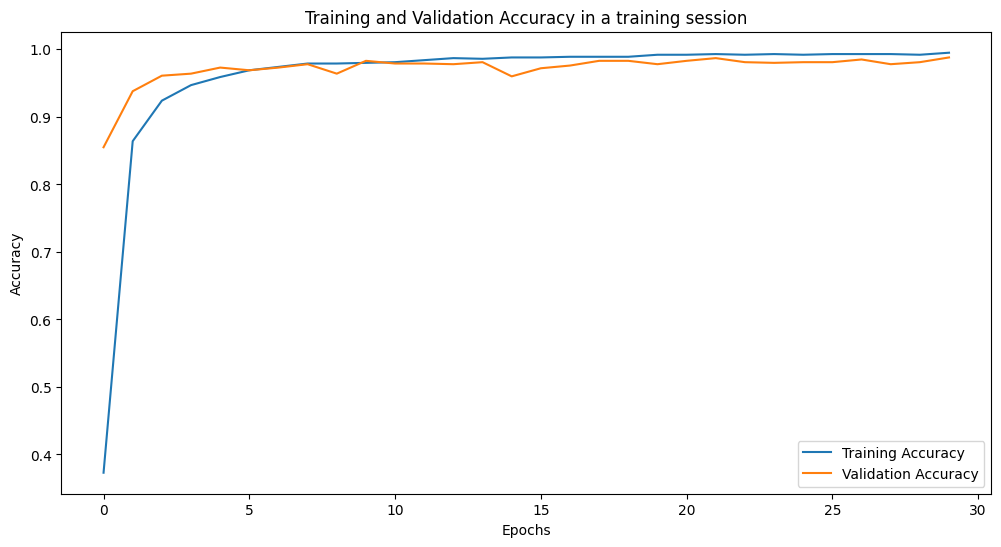

In [35]:
# Load and transform the experiment log
param_columns = ['conv1_filters', 'conv2_filters', 'conv3_filters', 'dense_units', 'dropout_rate', 'learning_rate', 'batch_size', 'epochs']
transformed_log = load_and_transform_log(param_cols=param_columns)
print("Transformed Log:")
print(transformed_log.head())

# Filter and display results with val_accuracy > 0.8
filtered_log = filter_dataframe(transformed_log)
print("Filtered Results (val_accuracy > 0.8):")
print(filtered_log)

# ######################## Use custom threshhold

# # Load and transform the experiment log with custom thresholds
# transformed_log = load_and_transform_log(accuracy_threshold=0.85, val_accuracy_threshold=0.83)
# print("Transformed Log:")
# print(transformed_log.head())

# # Filter and display results with val_accuracy > threshold
# filtered_log = filter_dataframe(transformed_log, accuracy_threshold=0.85, val_accuracy_threshold=0.83)
# print("Filtered Results (val_accuracy > 0.85):")
# print(filtered_log)

###########################
# Plot for a single training session
plot_accuracy(transformed_log, single_session=True)

# Plot for multiple training sessions(only show val_accuracy)
# plot_accuracy(transformed_log, use_filter=True)


### Test with test dataset
For the test set, I created a table in Word with all the bopomofo characters inside. I selected different computer fonts for the characters and then did screenshots.

For handwriting, I gave the the writer a table with instruction on how to fill out the table, then I did a screen shot or took a pecture of their work.

To make the test more reliable, I had my test set characters in various orders, with different combinations.

See more in "note.txt"

In [36]:
# info to log in prediction result
model_id = "36"
test_set = " 18_T1, 19_1"
test_data_notes = "computer font in order"


In [37]:
# Only charNum 01-37 contain characters, 38-42 are just blank.

# # T2 order
# char_numbers = [
#     [12,33,22,7,14,31,20,1,10,16,3,8,17,28],
#     [34,11,13,21,6,4,15,27,2,26,25,18,29,9],
#     [35,23,24,32,36,38,5,37,39,19,30,40,41,42]
# ]

# T1 order (normal order)
char_numbers = [
    list(range(1, 15)),   # Top row: 01-14
    list(range(15, 28)) + [38],  # Middle row: 15-17, 38
    list(range(28, 38)) + list(range(39, 43))  # Bottom row: 28-37, 39-42
]

# Check if the charNum matches the grid
print(char_numbers)

unprocessed_dir = 'test_unprocessed'
already_split_dir = 'test_split'
split_and_scaled_dir = 'test_processed_scaled'

# clear the folder before putting in new image
folder_path = already_split_dir
clear_folder(folder_path)
folder_path = split_and_scaled_dir
clear_folder(folder_path)



[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38], [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42]]
Function clear_folder has completed.
Function clear_folder has completed.


In [38]:
# # intput and output folder for split_all_images
# input_dir = 'test_unprocessed'
# output_dir = 'test_split'

# Split the image in the input directory
split_all_images(unprocessed_dir, already_split_dir, char_numbers)

In [39]:
# Parameters for scaling and padding
# input_dir = 'test_split'

# scaled_output_dir = 'test_processed_scaled'
target_size = (28, 28)  # Desired size for training

# Scale and pad images
scale_and_pad_image(already_split_dir, split_and_scaled_dir, target_size)

#### Data Exploration:
- Visualize Samples

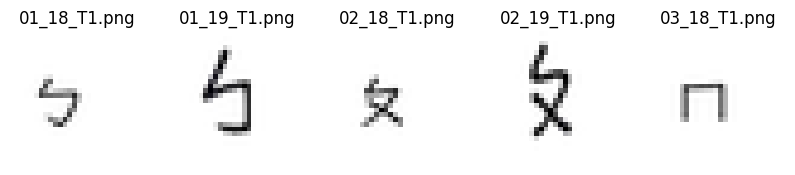

In [40]:
# Visualize some samples
# data_dir = 'test_processed_scaled'
# data_dir = 't2-0'

visualize_samples(split_and_scaled_dir)

In [41]:
# Load and preprocess test data
test_images, test_labels = load_and_preprocess_images(split_and_scaled_dir)

# Verify shapes and label range
print("test image shape:", test_images.shape)
print("Label range in test:", min(test_labels), "to", max(test_labels))

test image shape: (74, 28, 28, 1)
Label range in test: 0 to 36


In [42]:
def log_prediction_result(log_file='prediction_log.json', model_id=None, test_set=None, accuracy=None, report=None, conf_matrix=None, test_data_size=None, order_of_characters=None, test_data_notes=None, prediction_notes=None):
    # Read existing log file to find the highest existing ID
    if os.path.exists(log_file):
        with open(log_file, 'r') as file:
            log_data = json.load(file)
        if log_data:
            max_id = max(entry['result_id'] for entry in log_data)
        else:
            max_id = 0
    else:
        log_data = []
        max_id = 0
    
    new_id = max_id + 1
    timestamp = datetime.datetime.now().isoformat()

    result = {
        'result_id': new_id,  # Incremental result ID
        'model_id': model_id,
        'test_set': test_set,
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': conf_matrix.tolist(),  # Convert numpy array to list for JSON serialization
        'test_data_size': test_data_size,
        'order_of_characters': order_of_characters,
        'test_data_notes': test_data_notes,  # Notes on test data
        'prediction_notes': prediction_notes,  # Notes on prediction result
        'timestamp': timestamp  # Timestamp
    }

    log_data.append(result)

    with open(log_file, 'w') as file:
        json.dump(log_data, file, indent=4)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted Classes: [[9.99999881e-01 3.08481751e-09 3.34666443e-26 ... 6.74673828e-27
  9.10868026e-24 3.10703940e-31]
 [8.30944742e-14 1.44353758e-15 1.06321926e-26 ... 2.58358171e-32
  2.42038328e-33 7.44830017e-21]
 [1.10553285e-21 9.99999881e-01 0.00000000e+00 ... 0.00000000e+00
  7.74259582e-16 0.00000000e+00]
 ...
 [2.13923739e-36 9.00640326e-25 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 8.29582392e-32]
 [2.25992403e-09 6.19316654e-10 3.40862061e-05 ... 8.12464714e-06
  9.58670032e-09 9.80543673e-01]
 [2.04536007e-17 4.21510625e-20 3.67502015e-14 ... 5.31350925e-05
  4.19996286e-12 9.99781072e-01]]
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00 

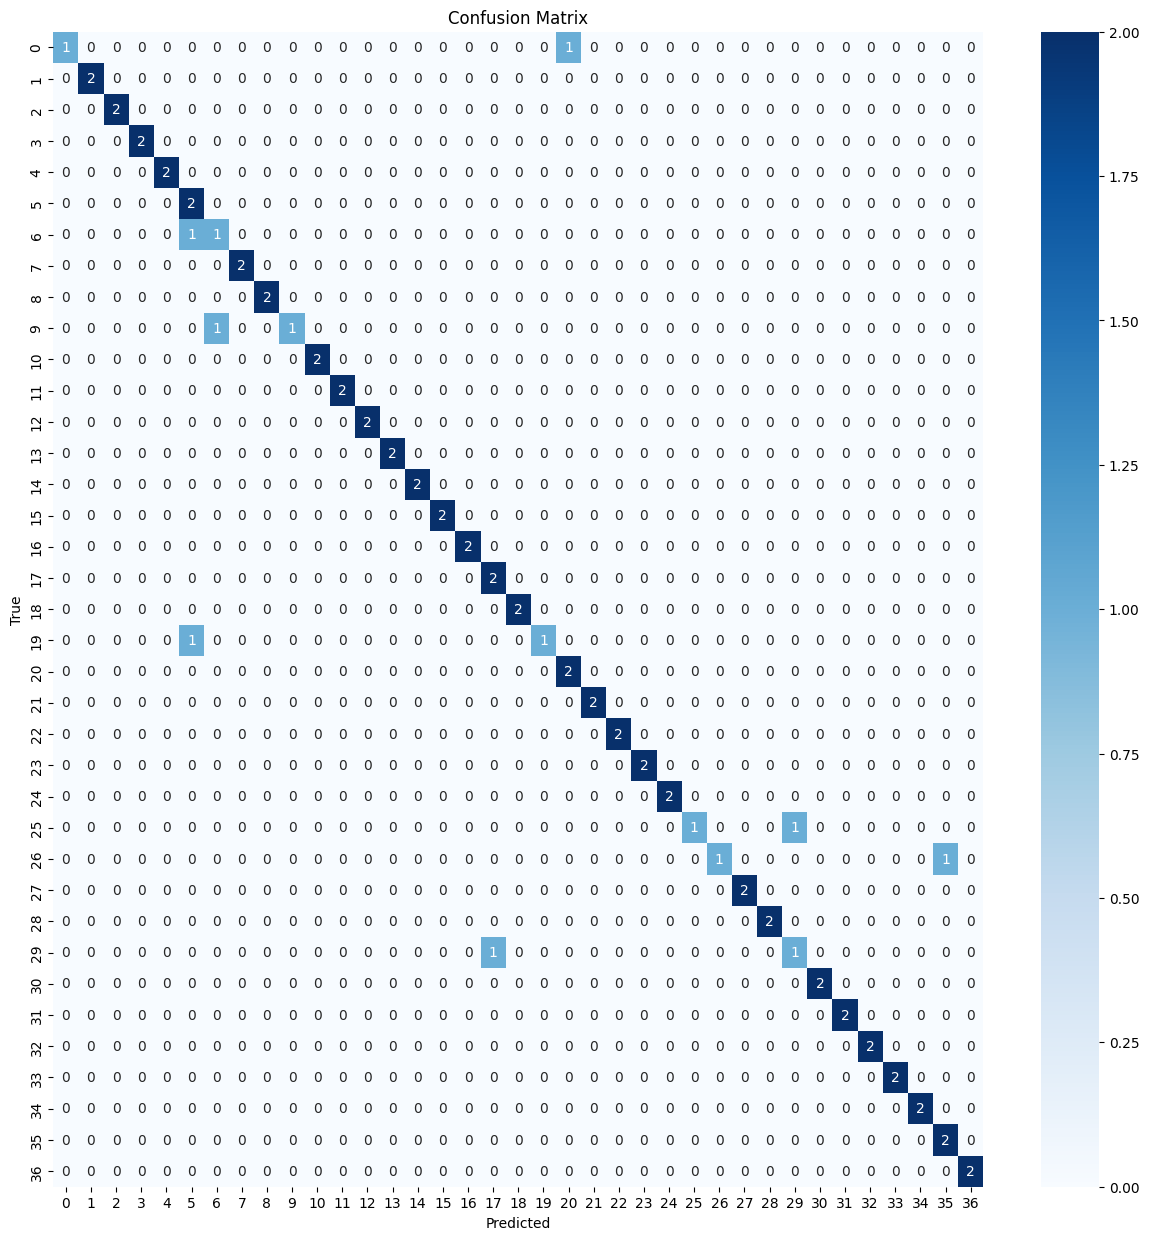

In [43]:
# Make predictions on the test data
predictions = model.predict(test_images)

# Print the predicted classes
print("Predicted Classes:", predictions)

# For classification, get the class with the highest probability 
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model by comparing predictions with true labels
accuracy = accuracy_score(test_labels, predicted_classes)
report = classification_report(test_labels, predicted_classes, zero_division=1)

# Print the evaluation results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

# Assuming you have the true labels (test_labels) and predicted labels (predicted_classes)
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(37), yticklabels=range(37))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [44]:

# log prediction result
test_data_size = len(test_images)
order_of_characters = char_numbers 
prediction_notes = "By removing the one set that is more off centerd, now have 85% accuracy."

log_prediction_result(log_file="prediction_log.json", model_id=model_id, test_set=test_set, accuracy=accuracy, report=report, conf_matrix=conf_matrix, test_data_size=test_data_size, order_of_characters=order_of_characters, test_data_notes=test_data_notes, prediction_notes=prediction_notes)